In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame,Series
from FlowControl import add_to_class

<h1>Support Vector Machines</h1>

<h2>1. Quadratic programming</h2>

Quadratic programming is a technique used in optimization problems, which can be formulated as following:
$$
\min_{\vec{x}} \Big(\frac{1}{2}\vec{x}^{T}Q\vec{x} + \vec{c} \cdot \vec{x}\Big) \hspace{1cm} \text{s.t.} \hspace{1cm} 
\left\{
\begin{array}{l}
(E\vec{x})_{j} \leq (\vec{d})_{j} \\
A\vec{x} = \vec{b} \\
l_{j} \leq x_{j} \leq u_{j}
\end{array}
\right.
$$

<h3>1.1 Simple example</h3>

$$
Q = \left[
\begin{array}{cc}
2 & 1 \\
1 & 5 
\end{array}
\right] 
\hspace{2cm}
\vec{c} = \left[
\begin{array}{c}
-3 \\
-3
\end{array}
\right] 
$$

$$
A = \left[
\begin{array}{c}
1  \\
1  
\end{array}
\right] 
\hspace{2cm}
\vec{b} = \left[
\begin{array}{c}
3 \\
\end{array}
\right] 
$$

$$
E = \left[
\begin{array}{c}
1  \\
2  
\end{array}
\right] 
\hspace{2cm}
\vec{d} = \left[
\begin{array}{c}
7
\end{array}
\right] 
$$

In [2]:
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

In [3]:
Q = matrix([
    [2.,1.], 
    [1.,5.]
])

c = matrix([-3., -3.])

A = matrix([
    [1.0],
    [1.0]  
])
b = matrix([3.0]) 

G = matrix([
    [1.], 
    [2.]  
])

h = matrix([7.])

sol = solvers.qp(Q, c, G=G, h=h, A=A, b=b)
sol3 = solvers.qp(P=Q, q=c)

print("Optimal solution:", sol['x'])
print("Optimal value:", sol['primal objective'])

print("Optimal solution:", sol3['x'])
print("Optimal value:", sol3['primal objective'])


Optimal solution: [ 2.40e+00]
[ 6.00e-01]

Optimal value: -0.9000000000000004
Optimal solution: [ 1.33e+00]
[ 3.33e-01]

Optimal value: -2.5


In [4]:
Q_np = np.array(Q).reshape(2,2)
c_np = np.array(c).flatten()
A_np = np.array(A).flatten()
b_np = np.array(b)
G_np = np.array(G).flatten()
h_np = np.array(h).flatten()

sol_x = np.array(sol["x"]).flatten()
sol_x3 = np.array(sol3["x"]).flatten()


In [5]:
x0_ = np.arange(-5,5,0.01)
x1_ = np.arange(-5,5,0.01)

x0,x1 = np.meshgrid(x0_,x1_)

X = np.stack((x0,x1),axis = 2)

y_Q = (1/2) * np.sum(X * np.sum(Q_np[np.newaxis,np.newaxis,:,:] * X[:,:,np.newaxis,:],axis = 2),axis = 2)
y_c = np.sum(c_np[np.newaxis,np.newaxis,:] * X,axis = 2)
y_ = y_Q + y_c

y_constr = (-A_np[0]*x0_ + b_np[0]) / A_np[1]
y_constr_ineq = (-G_np[0]*x0_ + h_np[0]) / G_np[1]

class_y = (x1 <= y_constr_ineq) 


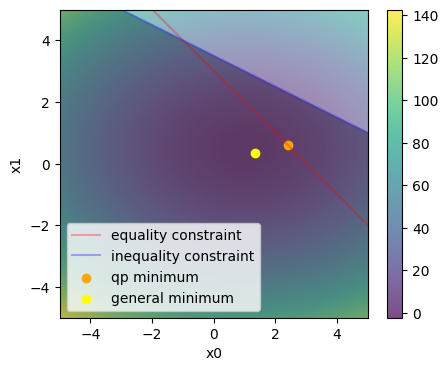

In [6]:
fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot()

im = ax.imshow(y_,extent = [x0_.min(),x0_.max(),x1_.min(),x1_.max()],origin = "lower",alpha = 0.7)
ax.imshow(class_y,extent = [x0_.min(),x0_.max(),x1_.min(),x1_.max()],origin = "lower",alpha = 0.25,cmap = "binary")
ax.plot(x0_,y_constr,color = "red",alpha=0.3,label = "equality constraint")
ax.plot(x0_,y_constr_ineq,color = "blue",alpha=0.3,label = "inequality constraint")
ax.scatter(sol_x[0],sol_x[1],color = "orange",marker = "o",label = "qp minimum")
ax.scatter(sol_x3[0],sol_x3[1],color = "yellow",marker = "o",label = "general minimum")
ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.legend()
ax.set_xlim(x0_.min(),x0_.max())
ax.set_ylim(x1_.min(),x1_.max())
fig.colorbar(im,ax= ax)
plt.show()

<h2>2. Margins</h2>

<h3>2.1 Functional and geometric margins</h3>

**Functional margin** of dataset $\{\vec{x}^{(i)},y^{(i)}\}$ is defined as:
$$
\hat{\gamma} = \min_{i}y^{(i)}\vec{\omega}\cdot \vec{x}^{(i)}
$$

**Geometric margin** of dataset $\{\vec{x}^{(i)},y^{(i)}\}$ is defined as:
$$
\gamma = \min_{i}y^{(i)}\hat{\omega}\cdot \vec{x}^{(i)}
$$
where $\hat{\omega}$ is normalized version of $\vec{\omega}$ with respect to feature subspace: 
$$
\hat{\omega} = (\vec{\theta},b)^T / |\vec{\theta}|
$$

$\gamma$ is simply the minimal distance between decision boundary and nearest data point. Furthermore, if we've found one of these two margins, we can find the other one by relation:
$$
\hat{\gamma }=|\vec{\theta}| \gamma 
$$

<h3>2.2 Margins maximization</h3>

If our dataset is linearly spearable, we can find the optimal parameters vector $\vec{\omega}$ by maximizing $\gamma$ subject to two constraints: $y^{(i)}\vec{\omega}\cdot \vec{x}^{(i)} \geq \gamma$ and $|\vec{\theta}| = 1$. In fact, we can loose the onstraint about proper normalization by maximizing $\hat{\gamma} / |\vec{\theta}|$. On the other hand, due to the freedom of choice of $\vec{\theta}$ we can choose it always as the one that gives us $\hat{\gamma} = 1$. Then the problem of maximization of $1/|\vec{\theta}|$ becomes:

- Minimize $\sum_{i=k}^{d}\omega_{k}^{2}$ subject to: $y^{(i)}\big(\sum_{k=1}^{d}\omega_{k}x_{k}^{(i)}+\omega_{d+1}\big) \geq 1$ for each $i=1,\ldots , n$

<h3>2.3 Lagrange multipliers</h3>

Cost function can be written as:
$$
\mathcal{L}(\vec{\omega},\lambda_{i}) = \frac{1}{2}\sum_{k=1}^{d}\omega_{k}^{2} - \sum_{i=1}^{n}\lambda_{i}\big( 
    y^{(i)}\vec{\omega}\cdot \vec{x}^{(i)} -1  \big) \hspace{1cm} \text{where} \hspace{1cm} \lambda_{i} > 0
$$|
Then we write the condition for the extremum:
$$
(\vec{\nabla}_{\vec{\omega}}\mathcal{L})_{j} = (\vec{\omega})_{j}(1-\delta_{j0})- \sum_{i=1}^{n}y^{(i)}\lambda_{i} x_{j}^{(i)} 
$$
and we obtain:
$$
(\vec{\theta})_{j} = \sum_{i=1}^{n}\lambda_{i}y^{(i)}x_{j}^{(i)}
$$
$$
\sum_{i=1}^{n}\lambda_{i}y^{(i)} = 0
$$

We can substitute the resulting values into our Lagrangian:
$$
\mathcal{L}(\vec{\omega},\lambda_{i}) = \frac{1}{2}\sum_{k=1}^{d}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_{i}\lambda_{j}y^{(i)}y^{(j)}x_{k}^{(i)}x_{k}^{(j)} - \sum_{k=1}^{d}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_{i}\lambda_{j}y^{(i)}y^{(j)}x_{k}^{(j)}  x_{k}^{(i)}  - \sum_{i=1}^{n}y^{(i)}\lambda_{i}\omega_{d+1}+
\sum_{i=1}^{n}\lambda_{i}
$$
$$
\mathcal{L}(\lambda_{i}) =\sum_{i=1}^{n}\lambda_{i} -\frac{1}{2}\sum_{k=1}^{d}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_{i}\lambda_{j}y^{(i)}y^{(j)}x_{k}^{(i)}x_{k}^{(j)} 

$$

Therefore we are ready to formulate the **dual problem**:
$$
\max_{\lambda_{i}}\mathcal{L}(\lambda_{i}) = \sum_{i=1}^{n}\lambda_{i} -\frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_{i}\lambda_{j}y^{(i)}y^{(j)}\langle \vec{x}^{(i)},\vec{x}^{(j)} \rangle _{d} \hspace{1cm} \text{s.t.} \hspace{1cm} 
\left\{
\begin{array}{l}
0\leq\lambda_{i} \\
\sum_{i=1}^{n}\lambda_{i}y^{(i)} = 0
\end{array}
\right.
$$

The problem can be solved with quadratic programing optimizer

<h3>2.4 Further heuristic derivation</h3>

Points that are in the neraest neighbourhood of the decision boundaries will be called **support vectors**.
Beacuse only support vectors are relevant to our problem, then only non-zero $\lambda_{i}$ are thouse corresponding to SVs. By the same reasoning we can infer, that bias coefficient can be obtained by applying the following formula:
$$
\omega_{d+1} = \frac{1}{n_{s}}\sum_{i \in SVs} (y^{(i)} - \vec{\theta}\cdot \vec{x}^{(i)})
$$
So that for the case of two classes:
$$
\omega_{d+1} = -\frac{1}{2}(\max_{y^{(i)} = -1}\vec{\theta}\cdot \vec{x}^{(i)}+ \min_{y^{(i)} = 1}\vec{\theta}\cdot \vec{x}^{(i)})
$$

<h2>3. Implementation</h2>

<h3>3.1 Synthetic data</h3>

In [7]:
from matplotlib import cm

In [8]:
def generate_2(seed,std_scale = 3.5):
    rng = np.random.default_rng(seed)
    data_sets = []
    y_sets = []
    total_size = 0
    for i in range(2):
        mu = rng.uniform(size = 2)*1.5
        stds = rng.uniform(size = 2) / std_scale
        size = rng.integers(50)+50
        total_size += size
        data_sets.append(np.array(
            [rng.normal(loc = mu[0],scale = stds[0],size = size),
            rng.normal(loc = mu[1],scale = stds[1],size = size)]
        ).T)
        y_sets.append(np.ones(size) * i)
    inds = rng.permutation(total_size)
    return np.vstack(data_sets)[inds],np.hstack(y_sets)[inds]

def plot_data_points(X_data,y_data,ax):
    k = len(np.unique(y_data))
    for i in range(k):
        inds = (y_data == i)
        ax.scatter(X_data[inds,0],X_data[inds,1],color = cm.viridis(i/k),label = f"class: {i}",alpha=0.9,marker = "o")
    ax.set_xlabel(r"$x_{0}$")
    ax.set_ylabel(r"$x_{1}$")

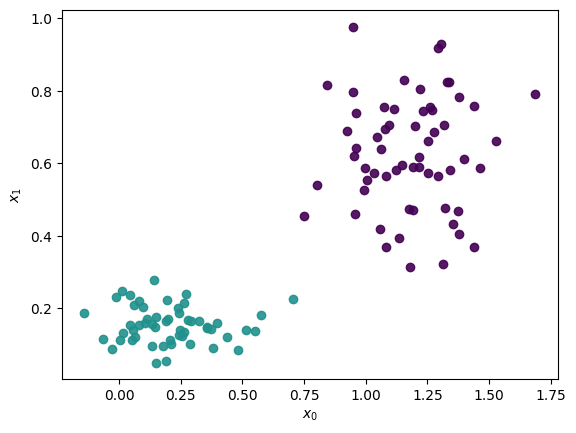

In [9]:
fig = plt.figure()
ax = fig.add_subplot()

X_data, y_data = generate_2(42,std_scale=3.5)
plot_data_points(X_data,y_data,ax)

<h3>3.2 SVM implementation</h3>

In [10]:
class LinearSVC:
    def __init__(self):
        pass

    def fit(self,X_data,y_data):
        raise NotImplementedError
    
    def predict(self,X_data):
        raise NotImplementedError

In [11]:
@add_to_class(LinearSVC)
def fit(self, X_data, y_data,**kwargs):
    if len(X_data.shape) == 2:
        n, d = X_data.shape
    else:
        n = X_data.shape[0]
        d = 1
    
    classes = np.unique(y_data)
    y_data = np.where(y_data == classes[0], -1, 1)

    K = X_data @ X_data.T

    P = matrix(np.outer(y_data, y_data) * K) 
    q = matrix(-np.ones(n))                               
    A = matrix(y_data.astype('double'), (1, n)) 
    b = matrix(0.0)                       
    if "C" in kwargs.keys():
        C = kwargs.get("C")
        G = matrix(np.vstack((-np.eye(n),np.eye(n))))                   
        h = matrix(np.hstack((np.zeros(n),np.ones(n)*C))) 
    else:
        G = matrix(-np.eye(n))                   
        h = matrix(np.zeros(n)) 
    
    lam = np.ravel(solvers.qp(P, q, G, h, A, b)["x"])

    eps = lam > 1e-5 # support vectors

    self.w_ = np.sum(lam[:,np.newaxis] * X_data * y_data[:,np.newaxis], axis=0)
    self.b_ = np.mean(y_data[eps] - (X_data @ self.w_)[eps]) 

    return self.w_, self.b_

@add_to_class(LinearSVC)
def predict(self, X_data):
    return np.sign(X_data @ self.w_ + self.b_)


In [12]:
model = LinearSVC()
th,b = model.fit(X_data,y_data)

In [13]:
x0_ = np.arange(-0.2,1.5,0.001)
x1_ = np.arange(-0.,1.1,0.001)

x0,x1 = np.meshgrid(x0_,x1_)
X_test_tot = np.stack((x0,x1),axis = 2)
X_test_prep = X_test_tot.reshape(-1,2)

y_pred_tot = model.predict(X_test_prep).reshape(len(x1_),len(x0_))


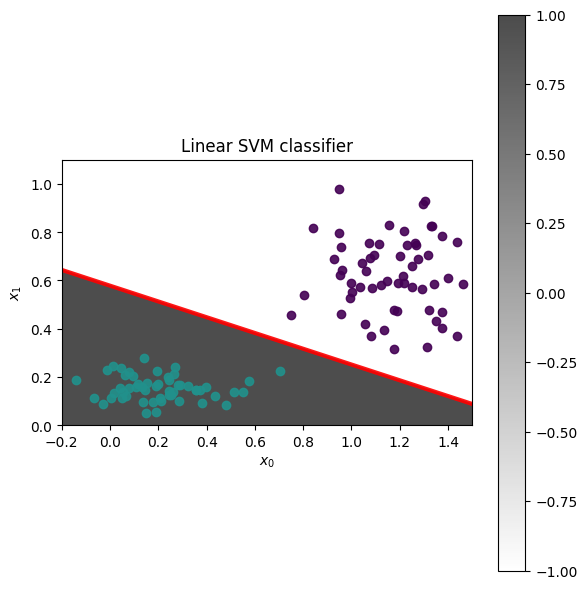

In [14]:
x_d = np.arange(-0.3,2,0.01)
y_svm = (-th[0] * x_d  - b) / th[1]

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot()

plot_data_points(X_data,y_data,ax)
ax.plot(x_d,y_svm,color = "red",alpha = 0.9,lw = 3)
im = ax.imshow(y_pred_tot,extent=[x0_.min(),x0_.max(),x1_.min(),x1_.max()],origin = "lower",cmap = "binary",alpha = 0.7)
ax.set_title("Linear SVM classifier")

fig.colorbar(im,ax = ax)
plt.tight_layout()
plt.show()

<h3>3.3 Linear SVM with non-separable data</h3>

If the data can't be separated by a linear function and if we want to make our model more robust to adding another data points, we should allow our margin to be less than 1. Therefore our primal problem can be reformulated as:
- Minimize $\sum_{i=k}^{d}\omega_{k}^{2} + C\sum_{i=1}^{n}\xi_{i}$ subject to: $y^{(i)}\big(\sum_{k=1}^{d}\omega_{k}x_{k}^{(i)}+\omega_{d+1}\big) \geq 1-\xi_{i}$, $\xi_{i} \geq 0$ for each $i=1,\ldots , n$.

This time, Lagrangian should be written as:
$$
\mathcal{L}(\vec{\omega},\lambda_{i},\xi_{i},\beta_{i}) = \frac{1}{2}\sum_{k=1}^{d}\omega_{k}^{2} +C\sum_{i=1}^{n}\xi_{i}- \sum_{i=1}^{n}\lambda_{i}\big( 
    y^{(i)}\vec{\omega}\cdot \vec{x}^{(i)} -1  +\xi_{i}\big) - \sum_{i=1}^{n}\beta_{i}\xi_{i} \hspace{1cm} \text{where} \hspace{1cm} \lambda_{i} \geq 0, \beta_{i} \geq 0
$$
$$
(\vec{\nabla}_{\xi}\mathcal{L})_{j} = C - \beta_{j} - \lambda_{j} = 0
$$
$$
\lambda_{j} = C - \beta_{j}  \leq C
$$


therefore the effective Lagrangian doesn't change, but now our Lagrange multiplyier $\lambda_{j}$ is limited by $C$. Dual problem can be reformulated as previously in terms of maximization of a convex function $\mathcal{L}(\lambda_{i})$:

$$
\max_{\lambda_{i}}\mathcal{L}(\lambda_{i}) = \sum_{i=1}^{n}\lambda_{i} -\frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_{i}\lambda_{j}y^{(i)}y^{(j)}\langle \vec{x}^{(i)},\vec{x}^{(j)} \rangle _{d} \hspace{1cm} \text{s.t.} \hspace{1cm} 
\left\{
\begin{array}{l}
0 \leq \lambda_{i} \leq C\\
\sum_{i=1}^{n}\lambda_{i}y^{(i)} = 0
\end{array}
\right.
$$

hyperparameter $C$ can be considered here as $\ell_{1}$ regularization hyperparameter. If it is near $0$ then there is no effective constraint for $\xi_{i}$, therefore the margin can be as really large. In the opposite case, if $C$ is very large, then $\xi_{i}$ should be samll and we obtain the non-regularized model.

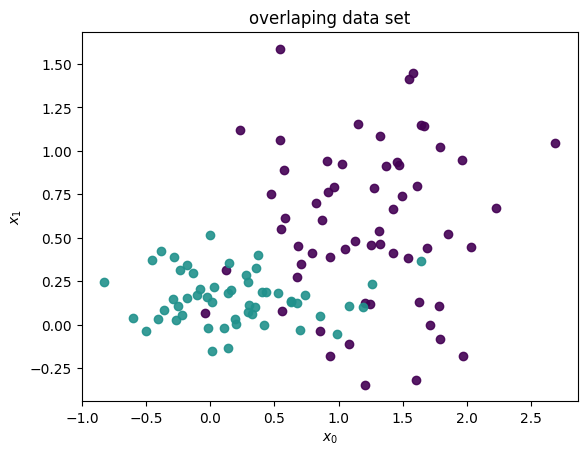

In [15]:
fig = plt.figure()
ax = fig.add_subplot()

X_data_ol, y_data_ol = generate_2(42,std_scale=1.2)
plot_data_points(X_data_ol,y_data_ol,ax)
ax.set_title("overlaping data set")
plt.show()

In [16]:
ths_ol = []
bs_ol = []
Cs = [0.1,1,10,100,1000000]
Colors = [cm.viridis(i / len(Cs)) for i in range(len(Cs)) ]
model_ol = LinearSVC()

for _,C in enumerate(Cs):
    th_temp,b_temp = model_ol.fit(X_data_ol,y_data_ol,C = C)
    ths_ol.append(th_temp)
    bs_ol.append(b_temp)

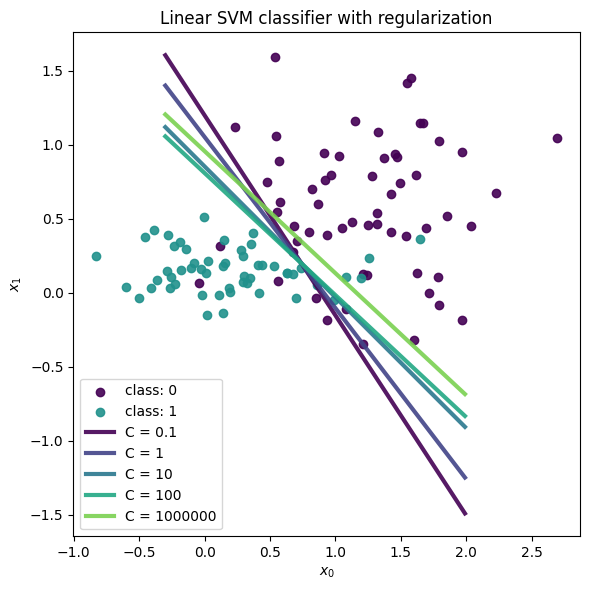

In [17]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot()
plot_data_points(X_data_ol,y_data_ol,ax)

y_svms = []
for i,zip_ in enumerate(zip(ths_ol,bs_ol)):
    th_,b_ = zip_
    y_svm_temp = (-th_[0] * x_d  - b_) / th_[1] 
    ax.plot(x_d,y_svm_temp,color = Colors[i],alpha = 0.9,lw = 3,label = f"C = {Cs[i]}")
ax.set_title("Linear SVM classifier with regularization")
ax.legend()
plt.tight_layout()
plt.show()